# **Assignment 1**
## 04
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

np.random.seed(10)
plt.style.use('ggplot')


def loadData():
    cNames = []
    Root = os.getcwd().replace("\\","/")
    with open(f"{Root}/datasets/communities.names") as reader:
        cNames = [r.split()[1] for r in reader if r.startswith("@attribute")]

    Data = pd.read_csv(f"{Root}/datasets/communities.data", sep=",", names = cNames, na_values='?') 
    Data = Data.drop(["state", "county", "community", "communityname", "fold"], axis=1)
    Data.insert(loc=0,column="x0",value=1)
    
    return Data


def fillMiss(Data,method):
    Data = Data.copy(deep=True)
    Mean = Data.mean()
    Std    = Data.std()

    for c in Data.columns:
        isNan = Data[c].isna()
        if not sum(isNan)==0:
            if method=='mean':
                Data.loc[isNan, c] = Mean[c]
            elif method=='normal':
                Data.loc[isNan, c] = np.random.normal(loc = Mean[c] , scale = Std[c], size=sum(isNan))
    
    return Data


def wCalculator(Data, lambd=0):
    X, Y, n, N = mathPrepration(Data)

    MP = np.linalg.inv( np.matmul(X.T,X) + lambd * np.eye(n) )
    W    = np.matmul( np.matmul(MP,X.T) , Y )
    
    return W


def mathPrepration(Data):
    X = Data.drop(["ViolentCrimesPerPop"], axis=1)
    X = np.matrix(X)
    n = np.shape(X)[1] 
    N = np.shape(X)[0]
    Y = np.array(Data["ViolentCrimesPerPop"]).reshape((N,1))
    
    return X, Y, n, N


def costFunction(Data , W, lambd=0):
    X, Y, n, N = mathPrepration(Data)
    E = (np.sum(np.power(Y-np.matmul(X,W),2)) + lambd * np.sum(np.power(W,2)))
    RMSE = np.sqrt(E/N)
    return RMSE

def dividingData(Data, ratio=0.8):
    Test    = Data.loc[:int(Data.shape[0]*(1-ratio)),:]
    Train = Data.loc[int(Data.shape[0]*(1-ratio)):,:]
    return Train, Test

def folding(Train, k=5):
    bounds    = np.ceil( np.linspace(Train.index[0],Train.index[-1],k+1) ).astype(int)
    Folds= [ [ Train.drop( range( bounds[i],bounds[i+1] )) ,
                        Train.loc [ range( bounds[i],bounds[i+1] )    ,: ] ] for i in range(k)]
    return Folds

def W_fold(Folds, k=5, lambd=0, Print=False):                    
    RMSE = np.zeros((k,1))
    Wk         = []

    for idx in range(k):
        W = wCalculator(Folds[idx][0], lambd)
        RMSE[idx] = costFunction(Folds[idx][1] , W, lambd)
        Wk.append(W)
    
    if Print:
        print("\n".join([f"RMSE of validation set (fold {i+1})= {RMSE[i][0]:0.3f}" for i in range(k)]))
    RMSE = RMSE.mean()
    W = np.mean(Wk,axis=0)
    return RMSE, W

In [2]:
print()
Data = loadData()
print("A sample column with NaN")
print(Data["PolicOperBudg"].head(5))
Data = fillMiss(Data,'mean')
print("\nThe sample filled with mean")
print(Data["PolicOperBudg"].head(5))
Data = loadData()
Data = fillMiss(Data,'normal')
print("\nThe sample filled with random normal distribution")
print(Data["PolicOperBudg"].head(5))



A sample column with NaN
0    0.04
1     NaN
2     NaN
3     NaN
4     NaN
Name: PolicOperBudg, dtype: float64

The sample filled with mean
0    0.040000
1    0.076708
2    0.076708
3    0.076708
4    0.076708
Name: PolicOperBudg, dtype: float64

The sample filled with random normal distribution
0    0.040000
1   -0.226826
2    0.350067
3    0.053343
4    0.050014
Name: PolicOperBudg, dtype: float64


In [3]:
Data = loadData()
Data = fillMiss(Data,'mean')

In [4]:
Train, Test = dividingData(Data, 0.8)
k=5
Folds = folding(Train, k=k)
RMSE_tr, W = W_fold(Folds,Print=True)
print(f"\nAverage RMSE for {k}-fold Train dataset = {RMSE_tr:0.3f}")
RMSE_test = costFunction( Test , W)
print(f"RMSE for Test dataset = {RMSE_test:0.3f}")

RMSE of validation set (fold 1)= 0.166
RMSE of validation set (fold 2)= 0.137
RMSE of validation set (fold 3)= 0.132
RMSE of validation set (fold 4)= 1.082
RMSE of validation set (fold 5)= 0.137

Average RMSE for 5-fold Train dataset = 0.331
RMSE for Test dataset = 0.142


Minimum of RMSE for train dataset: 0.140 , Corresponds to λ = 0.0160
RMSE for test dataset: 0.143 , Corresponds to λ = 0.0160


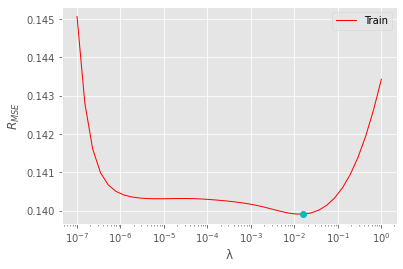

In [5]:
Lambd= 10**np.linspace(-7,0,40)
RMSE_tr = np.zeros((len(Lambd),1))
RMSE_te = np.zeros((len(Lambd),1))
  
for idx, lambd in enumerate(Lambd):
  RMSE_tr[idx], _ = W_fold(Folds, lambd=lambd)
  
arg = np.argmin(RMSE_tr)
L = Lambd[arg]
_, W = W_fold(Folds, lambd=L)
RMSE_te = costFunction(Test, W, L)
print(f"Minimum of RMSE for train dataset: {RMSE_tr[arg][0]:.3f} , Corresponds to \u03BB = {L:.4f}")
print(f"RMSE for test dataset: {RMSE_te:.3f} , Corresponds to \u03BB = {L:.4f}")

plt.plot(Lambd ,RMSE_tr,"r", label="Train", linewidth=1)
plt.plot(L,RMSE_tr[arg][0],"o",color="c")

plt.xlabel("\u03BB")
plt.xscale("log")
plt.ylabel("$R_{MSE}$")
plt.legend()



25 Important Feature as sorted:

 NumImmig
 numbUrban
 NumIlleg
 LemasSwornFT
 OfficAssgnDrugUnits
 PctNotSpeakEnglWell
 OwnOccLowQuart
 whitePerCap
 PctRecImmig5
 PolicBudgPerPop
 LemasTotalReq
 PctPersOwnOccup
 PctPopUnderPov
 PctKids2Par
 PctLargHouseOccup
 PersPerRentOccHous
 LemasSwFTPerPop
 medIncome
 RentLowQ
 TotalPctDiv
 agePct16t24
 PersPerFam
 PctPolicHisp
 PctLess9thGrade
 PctPolicBlack
Minimum of RMSE for train dataset: 0.146 , Corresponds to λ = 1e-07
RMSE for test dataset: 0.149 , Corresponds to λ = 1e-07


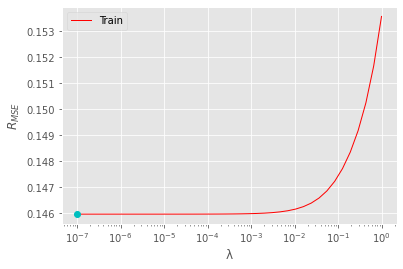

In [6]:
cor = np.divide(W.T,list(Data.mean()[0:-1]))
sortedF = np.argsort(cor)

fNum = 25
features = [Data.columns[sortedF[0][i]] for i in range(fNum)]
print(f"{fNum} Important Feature as sorted:\n")
print("\n".join([f" {features[i]}" for i in range(fNum)]))
features.append("ViolentCrimesPerPop")

newData = Data.copy(deep=True)
newData = newData[features]
Train, Test = dividingData(newData, 0.8)
Folds = folding(Train)

Lambd= 10**np.linspace(-7,0,40)
N_lambda = len(Lambd)
RMSE_tr = np.zeros(( N_lambda ,1))
RMSE_te = np.zeros(( N_lambda ,1))
  
for idx, lambd in enumerate(Lambd):
  RMSE_tr[idx], _ = W_fold(Folds, lambd=lambd)
  
arg = np.argmin(RMSE_tr)
L = Lambd[arg]
_, W_ = W_fold(Folds, lambd=L)
RMSE_te = costFunction(Test, W_, L)
print(f"Minimum of RMSE for train dataset: {RMSE_tr[arg][0]:.3f} , Corresponds to \u03BB = {L}")
print(f"RMSE for test dataset: {RMSE_te:.3f} , Corresponds to \u03BB = {L}")

plt.plot(Lambd ,RMSE_tr,"r", label="Train", linewidth=1)
plt.plot(L,RMSE_tr[arg][0],"o",color="c")

plt.xlabel("\u03BB")
plt.xscale("log")
plt.ylabel("$R_{MSE}$")
plt.legend()

